<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_7%5D_Camera_stickers(CV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.6.0
19.24.0


## 1.이미지 가져오기

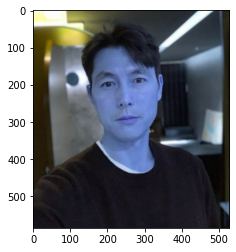

In [2]:
my_image_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_image/정우성_1.png"
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()      
plt.imshow(img_bgr)
plt.show()

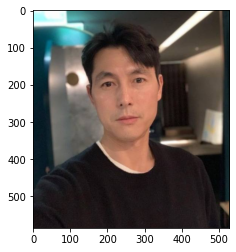

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 및 랜드마크 검출
- 오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

In [4]:
detector_hog = dlib.get_frontal_face_detector()

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(159, 139) (345, 325)]]


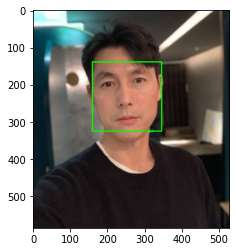

In [6]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2022-08-09 06:44:08--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  16.7MB/s    in 5.2s    

2022-08-09 06:44:13 (11.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [8]:
! mv shape_predictor_68_face_landmarks.dat.bz2 /content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_models

In [9]:
!cd /content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers && bzip2 -d ./camera_models/shape_predictor_68_face_landmarks.dat.bz2

bzip2: Output file ./camera_models/shape_predictor_68_face_landmarks.dat already exists.


In [10]:
model_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_models/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

In [11]:
list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
  points = landmark_predictor(img_rgb, dlib_rect)
  # face landmark 좌표를 저장해 둡니다.
  list_points = list(map(lambda p : (p.x,p.y), points.parts()))
  list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


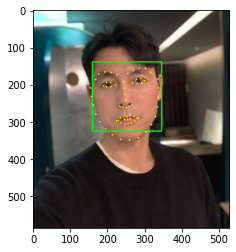

In [12]:
for landmark in list_landmarks:

  for point in landmark:

    cv2.circle(img_show, point, 2,(0,255,255),-1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 스티커 적용 위치 확인
- 고양이 수염이 적용 될 위치를 landmark를 사용해서 계산

In [13]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(248, 243)
(x,y) : (248,150)
(w,h) : (187,187)


In [14]:
sticker_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/camera_stickers/camera_image/cat-whiskers.png"
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

(187, 187, 3)


In [15]:
refined_x = x - w // 2
refined_y = y 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (155,150)


In [16]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (155,150)


## 4. 스티커 적용하기
- 오늘 배운 np.where를 사용해서 스티커를 적용
- 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. opencv 의 cv2.addWeighted() 를 참고하세요.

In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker>=255,sticker_area,img_sticker).astype(np.uint8)

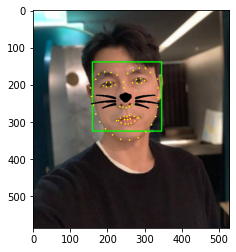

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

plt.show()

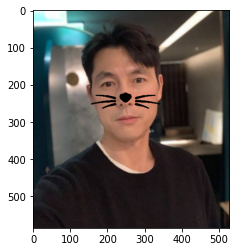

In [19]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker>0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

plt.show()

## 5. 문제점 찾아보기
- (1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

- (2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

  - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
  - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
  - 실행 속도가 중요할까요?
  - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?